# Exercise 1: Multiple Regression | Kyler Baldwin

## Imports

In [1]:

from IPython.display import display  # safe if running in Jupyter; harmless otherwise
import os
from pathlib import Path
import math

import numpy as np
import pandas as pd

import matplotlib.pyplot as plt
from matplotlib.figure import Figure
import seaborn as sns

import statsmodels.api as sm
import statsmodels.formula.api as smf
from statsmodels.stats.stattools import durbin_watson
from statsmodels.graphics.regressionplots import plot_leverage_resid2

import scipy.stats as stats
import patsy

from sklearn.model_selection import train_test_split
from sklearn.preprocessing import StandardScaler
from sklearn.linear_model import LinearRegression
from sklearn.feature_selection import RFE, RFECV
from sklearn import metrics

## Config

In [2]:

plt.rcParams["figure.figsize"] = (8, 4)
pd.set_option("display.width", 120)
pd.set_option("display.max_columns", None)

## Data Imports

In [3]:
bfp_df = pd.read_excel('BFP1_Data.xlsx')

display(bfp_df.head(3))
display(pd.DataFrame(bfp_df.isna().sum(), columns=["Nulls"]).T)

,id,colrcode,reliab,time,av_br,av_spec,price,credit,av_pay,return,warranty,talk_dir,reliab2,time2,av_br2,av_spec2,price2,credit2,return2,warrant2,satisf,rate,percent,i_acces,purch_i,purch_i2,purchgrp,often,rout_int,rout_cal,rout_sal,rout_no,fn_tech,fn_newpr,fn_need,fn_order,fn_pric,fn_other,pr_area,sales,num_emp,industry,size
0,1,8.0,8.0,8.0,6.0,7.0,7.0,5.0,8.0,7.0,7.0,8.0,7.0,6.0,6.0,7.0,8.0,5.0,6.0,5.0,9.0,7.0,2.0,1.0,0.0,0.0,0.0,3.0,0.0,1.0,0.0,0.0,1.0,0.0,0.0,0.0,0.0,0.0,1.0,5.0,6.0,34.0,large
1,5,8.0,9.0,9.0,9.0,9.0,9.0,7.0,6.0,8.0,8.0,9.0,5.0,4.0,8.0,8.0,7.0,5.0,6.0,7.0,6.0,6.0,2.0,1.0,1.0,0.0,0.0,2.0,0.0,1.0,0.0,0.0,1.0,0.0,0.0,0.0,0.0,0.0,1.0,NaN,5.0,30.0,NaN
2,9,5.0,8.0,7.0,4.0,8.0,5.0,1.0,1.0,5.0,6.0,7.0,5.0,5.0,5.0,5.0,5.0,5.0,5.0,5.0,NaN,NaN,1.0,1.0,0.0,0.0,0.0,3.0,0.0,0.0,0.0,1.0,0.0,0.0,1.0,0.0,0.0,0.0,2.0,NaN,3.0,34.0,NaN


,id,colrcode,reliab,time,av_br,av_spec,price,credit,av_pay,return,warranty,talk_dir,reliab2,time2,av_br2,av_spec2,price2,credit2,return2,warrant2,satisf,rate,percent,i_acces,purch_i,purch_i2,purchgrp,often,rout_int,rout_cal,rout_sal,rout_no,fn_tech,fn_newpr,fn_need,fn_order,fn_pric,fn_other,pr_area,sales,num_emp,industry,size
Nulls,0,1,4,4,6,6,4,9,8,7,5,4,11,11,13,15,13,23,20,18,8,9,27,1,3,4,9,8,5,5,5,5,10,10,10,10,10,10,1,54,10,5,54


# 1. Build a regression model to predict Satisf using only dealers’ perceived importance about choosing a supplier of hydraulic and pneumatic products. Variable names in the data are Reliab2, Time2, ….,Return2, Warranty2 as independent variables.

## Preprocessing

In [4]:
# select relevant columns
cols = ['satisf', 'reliab2', 'time2', 'av_br2', 'av_spec2', 'price2', 'credit2', 'return2', 'warrant2']
ols_bfp_df = bfp_df[cols].copy()
# drop rows with nulls
before_rows = ols_bfp_df.shape[0]
ols_bfp_df = ols_bfp_df.dropna()
after_rows = ols_bfp_df.shape[0]
print(f"Dropped {before_rows - after_rows} rows with nulls.")

Dropped 34 rows with nulls.


## Modeling

In [5]:
formula = 'satisf ~ reliab2 + time2 + av_br2 + av_spec2 + price2 + credit2 + return2 + warrant2'
X = ols_bfp_df.drop(columns=['satisf'])
y = ols_bfp_df['satisf']
lm = sm.OLS(y, sm.add_constant(X)).fit()
lm.summary()

<class 'statsmodels.iolib.summary.Summary'>
"""
                            OLS Regression Results                            
==============================================================================
Dep. Variable:                 satisf   R-squared:                       0.621
Model:                            OLS   Adj. R-squared:                  0.610
Method:                 Least Squares   F-statistic:                     56.15
Date:                Thu, 04 Sep 2025   Prob (F-statistic):           1.94e-53
Time:                        12:05:08   Log-Likelihood:                -469.59
No. Observations:                 283   AIC:                             957.2
Df Residuals:                     274   BIC:                             990.0
Df Model:                           8                                         
Covariance Type:            nonrobust                                         
==============================================================================
                 coef    std err          t      P>|t|      [0.025      0.975]
------------------------------------------------------------------------------
const          2.0266      0.481      4.213      0.000       1.080       2.974
reliab2        0.8019      0.086      9.360      0.000       0.633       0.971
time2          0.1481      0.073      2.033      0.043       0.005       0.291
av_br2        -0.0839      0.073     -1.150      0.251      -0.227       0.060
av_spec2       0.0649      0.065      1.002      0.317      -0.063       0.192
price2         0.0597      0.061      0.977      0.330      -0.061       0.180
credit2       -0.2610      0.067     -3.910      0.000      -0.392      -0.130
return2        0.2223      0.091      2.432      0.016       0.042       0.402
warrant2       0.0077      0.089      0.087      0.931      -0.167       0.183
==============================================================================
Omnibus:                       48.358   Durbin-Watson:                   2.163
Prob(Omnibus):                  0.000   Jarque-Bera (JB):              244.073
Skew:                          -0.546   Prob(JB):                     1.00e-53
Kurtosis:                       7.417   Cond. No.                         122.
==============================================================================

Notes:
[1] Standard Errors assume that the covariance matrix of the errors is correctly specified.
"""

In [6]:
y = lm.model.endog
y_mean = np.mean(y)

rmse = np.sqrt(lm.mse_resid)  # root mean square error
cv = (rmse / y_mean) * 100
print(f"Coefficient of Variation (CV): {cv:.2f}%")

Coefficient of Variation (CV): 14.94%


# Create a new variable (name it as Avg_Score) by averaging the three variables, Satisf, Rate and Percent. Then, run a stepwise regression with Avg_Score as dependent variable and Time2,……, Return2, Warrant2 as well as I_access, Puch_I, pr_area, num_emp and Industry as independent variables. Use p-value to enter as 0.05 and p-value to stay as 0.05.

## Preprocessing

In [7]:
# create Avg_Score by averaging satisf, rate, and percent
bfp_df["Avg_Score"] = bfp_df[["satisf", "rate", "percent"]].mean(axis=1)
# select relevant columns
cols = ['Avg_Score', 'reliab2', 'time2', 'av_br2', 'av_spec2', 
        'price2', 'credit2', 'return2', 'warrant2', 'i_acces', 
        'purch_i', 'pr_area', 'num_emp', 'industry']
step_bfp_df = bfp_df[cols].copy()   
# one-hot encode categorical variables
step_bfp_df = pd.get_dummies(step_bfp_df, columns=['pr_area', 'num_emp', 'industry'], drop_first=True, dtype=int)
step_bfp_df.columns = step_bfp_df.columns.str.replace('.', '', regex=False)
display(step_bfp_df.head(3))


,Avg_Score,reliab2,time2,av_br2,av_spec2,price2,credit2,return2,warrant2,i_acces,purch_i,pr_area_20,pr_area_30,pr_area_40,pr_area_50,pr_area_60,pr_area_70,num_emp_20,num_emp_30,num_emp_40,num_emp_50,num_emp_60,industry_240,industry_260,industry_300,industry_330,industry_340,industry_350,industry_370,industry_500,industry_760,industry_990
0,6.000000,7.0,6.0,6.0,7.0,8.0,5.0,6.0,5.0,1.0,0.0,0,0,0,0,0,0,0,0,0,0,1,0,0,0,0,1,0,0,0,0,0
1,4.666667,5.0,4.0,8.0,8.0,7.0,5.0,6.0,7.0,1.0,1.0,0,0,0,0,0,0,0,0,0,1,0,0,0,1,0,0,0,0,0,0,0
2,1.000000,5.0,5.0,5.0,5.0,5.0,5.0,5.0,5.0,1.0,0.0,1,0,0,0,0,0,0,1,0,0,0,0,0,0,0,1,0,0,0,0,0


## Modeling

In [8]:
## Wrapper around pandas method to subset the columns easily from a data frame 
def _model_data_subset(input_data: pd.DataFrame, column_subset: list =None) -> pd.DataFrame:  
    if column_subset is None: 
        return input_data 
    else: 
        model_subset_data = input_data[column_subset] 
        return model_subset_data

## Stepwise regression method where we give the p-value threshold 
## and the best subset regression model is built 
import statsmodels.api as sm 

def _stepwise_selection_p_val( 
    input_dataframe: pd.DataFrame, 
    target_variable_name: str, 
    column_subset: list = None, 
    SL_in: float = 0.05, 
    SL_out: float = 0.05, 
) -> [pd.DataFrame, pd.Series, list]:  # type: ignore
    model_subset_data = _model_data_subset(input_dataframe, column_subset) 
    model_subset_data_nona = model_subset_data.dropna() 

    target = model_subset_data_nona[target_variable_name] 
    x_variables_subset_data = model_subset_data_nona.drop(target_variable_name, axis=1) 

    initial_features = x_variables_subset_data.columns.tolist() 
    best_features = [] 

    while len(initial_features) > 0: 
        remaining_features = list(set(initial_features) - set(best_features)) 
        new_pval = pd.Series(index=remaining_features, dtype=float) 

        for new_column in remaining_features: 
            model = sm.OLS( 
                target, 
                sm.add_constant(model_subset_data_nona[best_features + [new_column]]),  
            ).fit() 
            new_pval[new_column] = model.pvalues[new_column] 

        min_p_value = new_pval.min() 
        if min_p_value < SL_in: 
            best_features.append(new_pval.idxmin()) 

            while len(best_features) > 0: 
                best_features_with_constant = sm.add_constant( 
                    model_subset_data_nona[best_features] 
                ) 
                p_values = sm.OLS(target, best_features_with_constant).fit().pvalues[1:]  
                max_p_value = p_values.max() 

                if max_p_value >= SL_out: 
                    excluded_feature = p_values.idxmax() 
                    best_features.remove(excluded_feature) 
                else: 
                    break 
        else: 
            break 

    return x_variables_subset_data, target, best_features

# The above function should not be called on its own. 
## This function does the variable selection and returns a regression model summary output 
def build_linear_regression_stepwise_based( 
    input_dataframe: pd.DataFrame, 
    target_variable_name: str, 
    column_subset: list = None, 
    SL_in: float = 0.05, 
    SL_out: float = 0.05, 
) -> [list, list]:  # type: ignore
    x_variables_subset_data, target_variable, best_features = _stepwise_selection_p_val(  
        input_dataframe, target_variable_name, column_subset, SL_in=SL_in, SL_out=SL_out  
    ) 

    dataframe_subset_best_features = x_variables_subset_data[best_features] 
    regression_model = sm.OLS( 
        target_variable, sm.add_constant(dataframe_subset_best_features) 
    ).fit() 

    print("The best features are ", best_features) 
    return regression_model, best_features

In [9]:
# run stepwise regression
col_subset = step_bfp_df.columns.tolist()
step_model, step_features = build_linear_regression_stepwise_based(step_bfp_df, "Avg_Score", col_subset, 0.05, 0.05)
display(step_model.summary())

The best features are  ['reliab2', 'industry_240', 'av_spec2', 'credit2']


<class 'statsmodels.iolib.summary.Summary'>
"""
                            OLS Regression Results                            
==============================================================================
Dep. Variable:              Avg_Score   R-squared:                       0.505
Model:                            OLS   Adj. R-squared:                  0.498
Method:                 Least Squares   F-statistic:                     71.00
Date:                Thu, 04 Sep 2025   Prob (F-statistic):           2.30e-41
Time:                        12:05:08   Log-Likelihood:                -412.92
No. Observations:                 283   AIC:                             835.8
Df Residuals:                     278   BIC:                             854.1
Df Model:                           4                                         
Covariance Type:            nonrobust                                         
================================================================================
                   coef    std err          t      P>|t|      [0.025      0.975]
--------------------------------------------------------------------------------
const            1.5701      0.349      4.496      0.000       0.883       2.258
reliab2          0.5875      0.045     12.938      0.000       0.498       0.677
industry_240     0.8107      0.257      3.152      0.002       0.304       1.317
av_spec2         0.1540      0.047      3.297      0.001       0.062       0.246
credit2         -0.1116      0.045     -2.470      0.014      -0.201      -0.023
==============================================================================
Omnibus:                       89.442   Durbin-Watson:                   1.808
Prob(Omnibus):                  0.000   Jarque-Bera (JB):              653.614
Skew:                          -1.062   Prob(JB):                    1.17e-142
Kurtosis:                      10.136   Cond. No.                         68.9
==============================================================================

Notes:
[1] Standard Errors assume that the covariance matrix of the errors is correctly specified.
"""

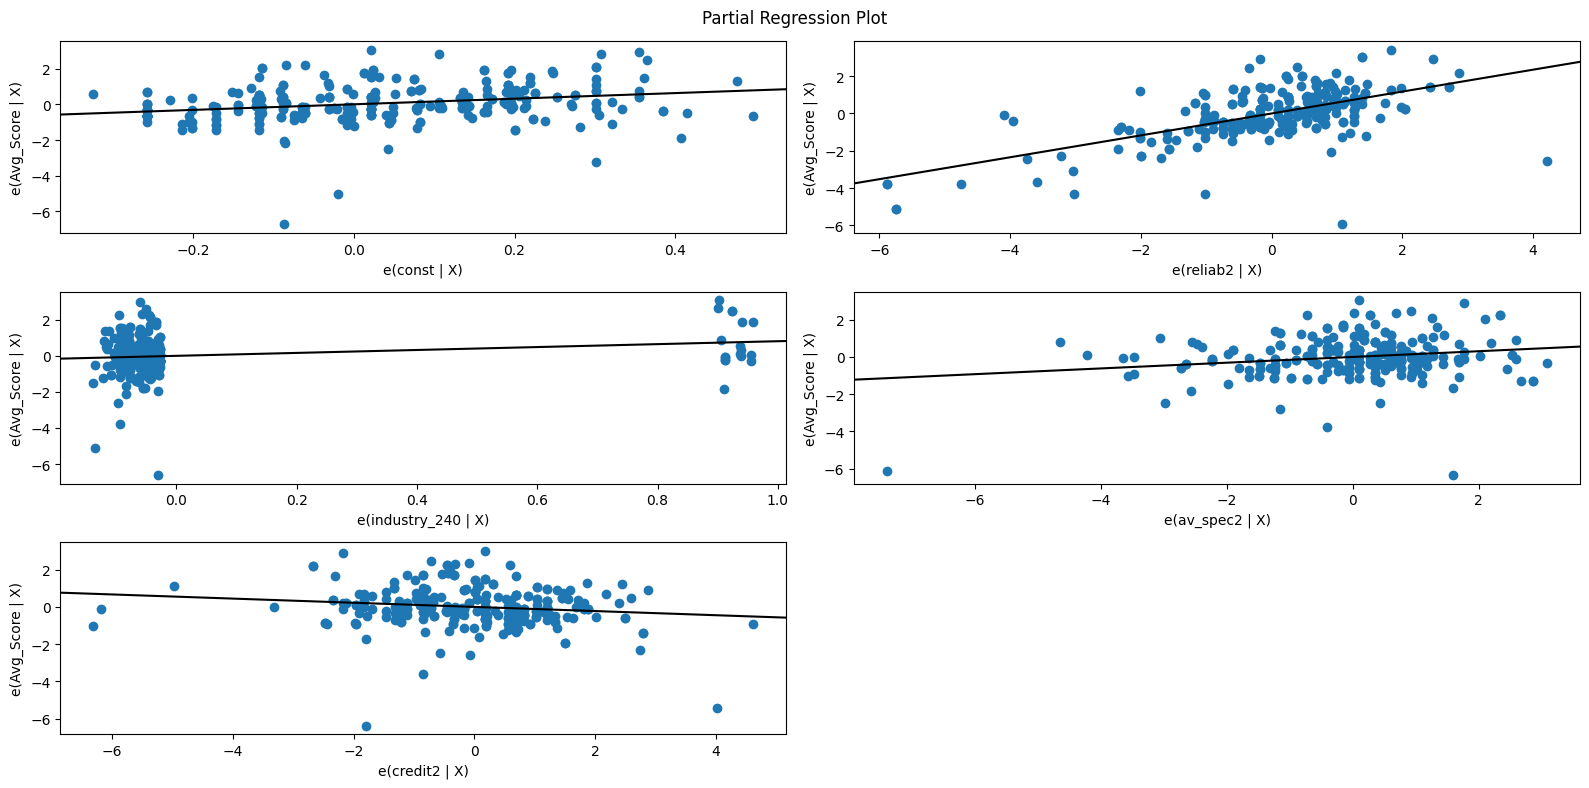

In [10]:
plt.rcParams["figure.figsize"] = (16, 8)
fig = sm.graphics.plot_partregress_grid(step_model)
plt.tight_layout()
plt.show()

a.	Which independent variables are retained in the final model in 2(a)? (0.25 point)

In [11]:
print(step_features)

['reliab2', 'industry_240', 'av_spec2', 'credit2']


b.	Create a studentized residual plot for the model in 2(a) and comment on it (0.25 point)

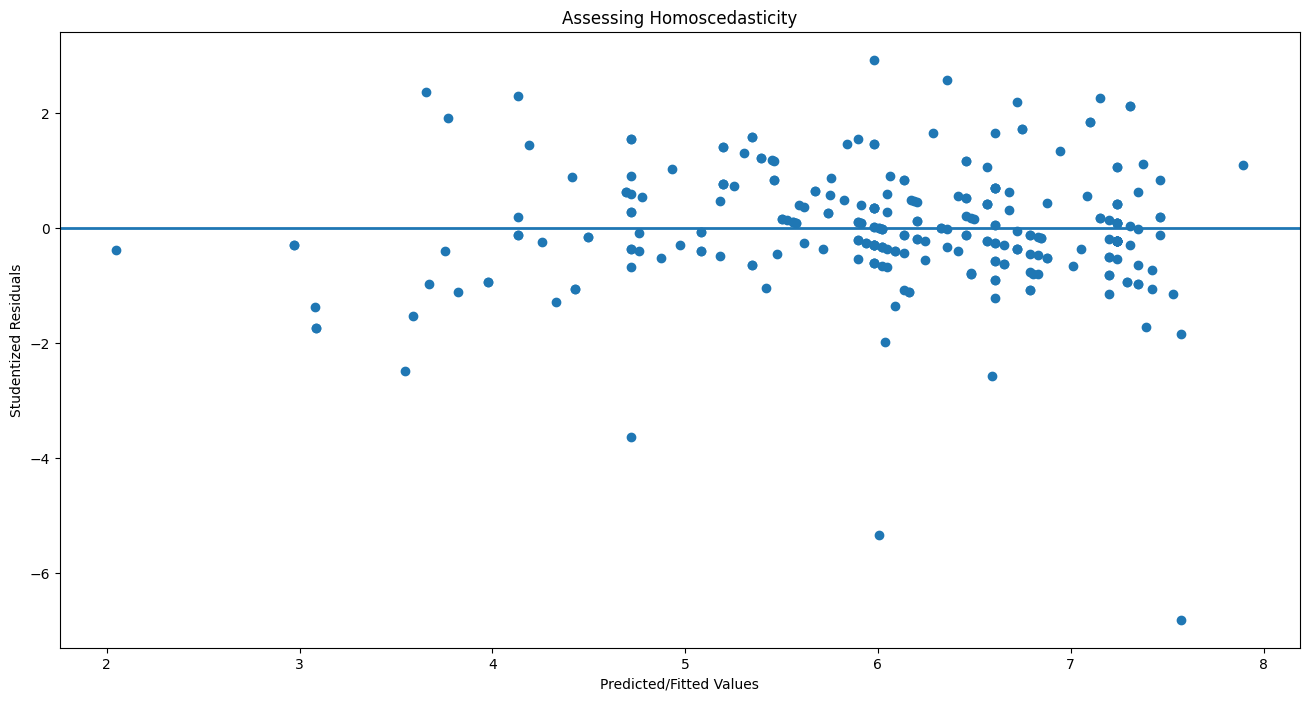

In [12]:
stud_residuals_df = step_model.outlier_test()  # returns DF with 'student_resid'
stud_residuals = stud_residuals_df["student_resid"]
plt.figure()
plt.scatter(step_model.fittedvalues, stud_residuals)
plt.axhline(0, lw=2)
plt.xlabel('Predicted/Fitted Values')
plt.ylabel('Studentized Residuals')
plt.title('Assessing Homoscedasticity')
plt.show()

c.	Report the Durbin-Watson statistic for the model in 2(a) and comment on it. (0.25 point)

In [13]:
dw = durbin_watson(step_model.resid, axis=0)
print(f"\nDurbin–Watson: {dw:.3f}")


Durbin–Watson: 1.808


d.	Create a Normality plot of studentized residuals for the model in 2(a) and comment on it. (0.25 point)

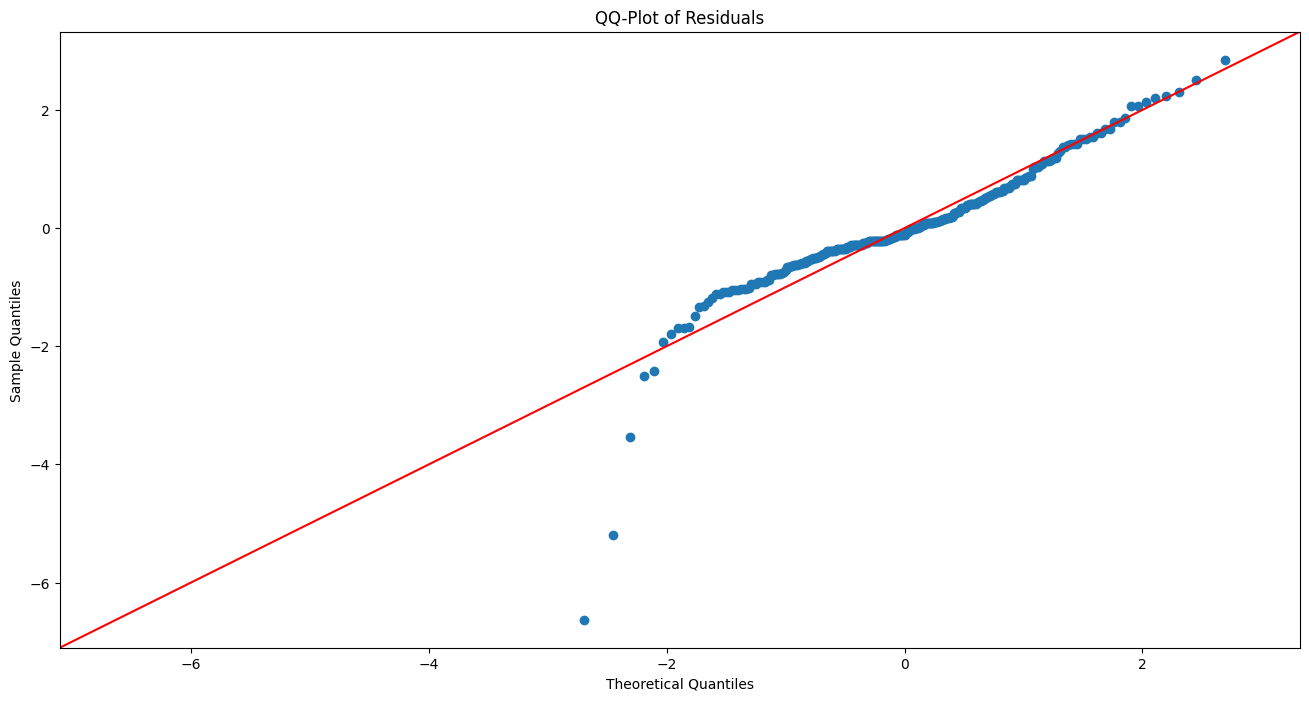

In [14]:
# plt.figure()
# stats.probplot(stud_residuals, dist="norm", plot=plt)
# plt.title("Probability Plot of Residuals")
# plt.show()

sm.qqplot(stud_residuals, fit=True, line='45')
plt.title("QQ-Plot of Residuals")
plt.show()

# plt.figure(figsize=(6, 3))
# sns.histplot(stud_residuals, bins=10, kde=True)
# plt.title("Histogram of Studentized Residuals")
# plt.show()

e.	Go online, research and create a code snippet to run a normality test (Shapiro-Wilk or, K-S) for the studentized residuals and comment on it. While, I may not have demonstrated it in the Python notebook, but this is your chance to show me you are curious (remember core values for BAnDS, i.e., ICARE). Add the code snippet to your results in answering this question and remember to explain your results. (2 points)

In [15]:
statistic, p_value = stats.shapiro(stud_residuals)
print(f"\nShapiro-Wilk Test: W={statistic:.3f}, p-value={p_value:.6f}")


Shapiro-Wilk Test: W=0.892, p-value=0.000000


f.	Do a sequence plot of the residuals and comment on it. (0.25 point)

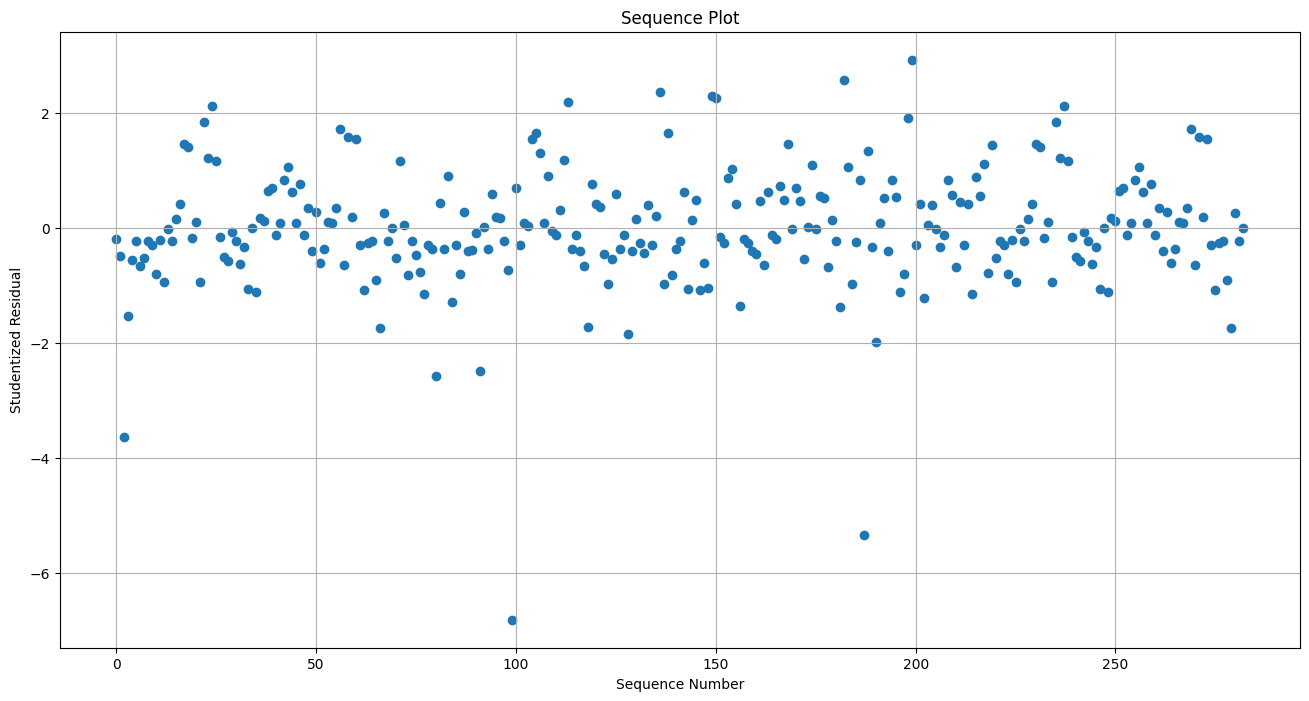

In [16]:
plt.figure()
plt.scatter(range(len(stud_residuals)), stud_residuals)
plt.grid(True)
plt.xlabel("Sequence Number")
plt.ylabel("Studentized Residual")
plt.title("Sequence Plot")
plt.show()

g.	Show the leverage plots for the most important independent variable in the and comment on it. (0.50 point)

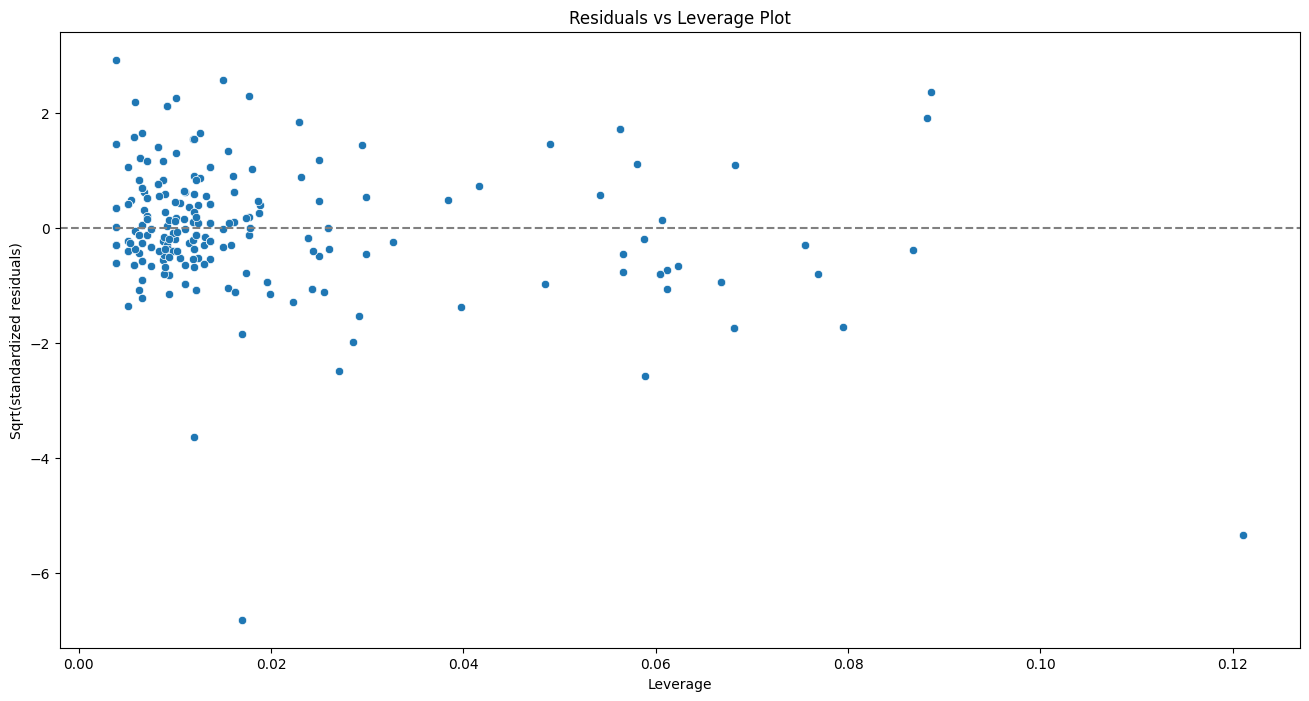

In [17]:
influence = step_model.get_influence()
leverage = influence.hat_matrix_diag

# Residual vs Leverage Plot
fig = sns.scatterplot(x=leverage, y=stud_residuals)
fig.axhline(y=0, color='grey', linestyle='dashed')
fig.set_xlabel('Leverage')
fig.set_ylabel('Sqrt(standardized residuals)')
fig.set_title('Residuals vs Leverage Plot')
plt.show()
# exog_others = [c for c in step_features if str(c).lower() not in {"reliab2", "const"}]
# cols_needed = ["Avg_Score", "reliab2"] + exog_others
# sub = step_bfp_df[cols_needed].copy()
# sub = sub.apply(pd.to_numeric, errors="coerce").dropna(axis=0)
# fig = sm.graphics.plot_partregress(
#     endog="Avg_Score",
#     exog_i="reliab2",
#     exog_others=exog_others,
#     data=sub,
#     obs_labels=False
# )
# plt.title("Leverage / Partial Regression Plot: Avg_Score ~ reliab2 | others")
# plt.tight_layout()
# plt.show()


h.	Report the VIFs for all variables for the model in 2(a) and comment on it. (0.25 point)

In [18]:
def vif_table(X_df: pd.DataFrame) -> pd.DataFrame:
    """Compute VIF for each column in X_df using OLS with intercept."""
    X = X_df.copy()
    out = []
    for col in X.columns:
        y = X[col]
        others = X.drop(columns=[col])
        X_const = sm.add_constant(others, has_constant='add')
        rsq = sm.OLS(y, X_const).fit().rsquared
        vif = np.inf if rsq >= 1.0 else round(1 / (1 - rsq), 2)
        out.append({"feature": col, "VIF": vif})
    return pd.DataFrame(out).sort_values("VIF", ascending=False).reset_index(drop=True)

X = step_bfp_df[step_features].dropna()
vif_df = vif_table(X)
display(vif_df)

,feature,VIF
0,av_spec2,1.54
1,reliab2,1.38
2,credit2,1.27
3,industry_240,1.01


i.	Go online, research and create a cope snippet that produces SBC (Schwartz’s Bayesian Criteria). While, I may not have demonstrated it in the Python notebook, but this is your chance to show me you are curious (remember core values for BAnDS, i.e., ICARE). Then run the code for both the model in #1 and in #2. Add the code snippet to your results in answering this question. Then explain which one a better model is using the SBC criteria. and explain your results. (2 points)

In [19]:
ols_bic = lm.bic
step_bic = step_model.bic
print(f"\nOLS BIC: {ols_bic:.3f}, Stepwise BIC: {step_bic:.3f}")


OLS BIC: 989.980, Stepwise BIC: 854.066


j.	Consider all of the variables in the model developed in 2(a). Can you test if the effect of the most important independent variable on Y depends on the size of the firm? Explain your results. (3 points)

In [20]:
# Yes use interaction terms
## most important IV from stepwise regression
preds = ['reliab2']

## one-hot encoded size dummies (number of employees)
## filtered to only num_emp_60 since it was the only significant one
emp_cols = ['num_emp_60']
step_bfp_df = step_bfp_df[step_features + emp_cols + ['Avg_Score']].copy()

## create interaction columns
for p in preds:
    for e in emp_cols:
        new_col = f"{p}_x_{e}"
        step_bfp_df[new_col] = step_bfp_df[p] * step_bfp_df[e]

step_bfp_df = step_bfp_df.dropna().copy()

X = step_bfp_df.drop(columns=['Avg_Score'])
y = step_bfp_df['Avg_Score']
lm = sm.OLS(y, sm.add_constant(X)).fit()
terms = []
for name, val in lm.params.items():
    if name == "const":
        terms.append(f"{val:.3f}")
    else:
        terms.append(f"{val:.3f}*{name}")
equation = " + ".join(terms)
print("Avg_Score_hat =", equation)
display(lm.summary())

Avg_Score_hat = 1.189 + 0.652*reliab2 + 0.848*industry_240 + 0.143*av_spec2 + -0.116*credit2 + 1.642*num_emp_60 + -0.230*reliab2_x_num_emp_60


<class 'statsmodels.iolib.summary.Summary'>
"""
                            OLS Regression Results                            
==============================================================================
Dep. Variable:              Avg_Score   R-squared:                       0.521
Model:                            OLS   Adj. R-squared:                  0.511
Method:                 Least Squares   F-statistic:                     51.24
Date:                Thu, 04 Sep 2025   Prob (F-statistic):           1.80e-42
Time:                        12:05:10   Log-Likelihood:                -417.28
No. Observations:                 290   AIC:                             848.6
Df Residuals:                     283   BIC:                             874.3
Df Model:                           6                                         
Covariance Type:            nonrobust                                         
========================================================================================
                           coef    std err          t      P>|t|      [0.025      0.975]
----------------------------------------------------------------------------------------
const                    1.1890      0.371      3.208      0.001       0.459       1.919
reliab2                  0.6519      0.050     12.980      0.000       0.553       0.751
industry_240             0.8476      0.253      3.351      0.001       0.350       1.345
av_spec2                 0.1429      0.046      3.126      0.002       0.053       0.233
credit2                 -0.1156      0.044     -2.620      0.009      -0.203      -0.029
num_emp_60               1.6425      0.633      2.596      0.010       0.397       2.888
reliab2_x_num_emp_60    -0.2297      0.090     -2.558      0.011      -0.406      -0.053
==============================================================================
Omnibus:                       84.083   Durbin-Watson:                   1.835
Prob(Omnibus):                  0.000   Jarque-Bera (JB):              580.545
Skew:                          -0.974   Prob(JB):                    8.63e-127
Kurtosis:                       9.652   Cond. No.                         134.
==============================================================================

Notes:
[1] Standard Errors assume that the covariance matrix of the errors is correctly specified.
"""

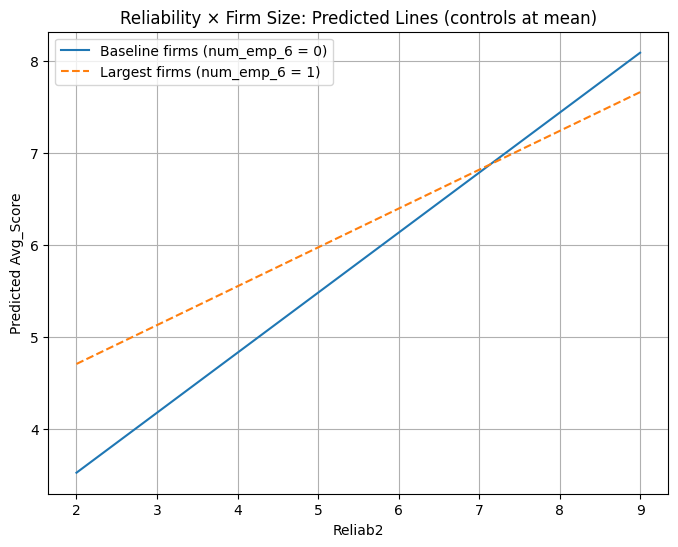

In [21]:
# --- coefficients ---
b0  = 1.189
b_rel = 0.652
b_ind = 0.848
b_avs = 0.143
b_cred = -0.116
b_emp6 = 1.642
b_rel_emp6 = -0.230

# --- control other vars ---
ind_mean = 1
av_spec2_mean = step_bfp_df["av_spec2"].mean()
credit2_mean = step_bfp_df["credit2"].mean()

# --- x-range for reliab2 ---
x = np.linspace(step_bfp_df["reliab2"].min(), step_bfp_df["reliab2"].max(), 200)

# --- prediction functions ---
def y_hat_baseline(x):
    return (b0 
            + b_ind*ind_mean 
            + b_avs*av_spec2_mean 
            + b_cred*credit2_mean) + b_rel*x

def y_hat_emp6(x):
    return (b0 
            + b_ind*ind_mean 
            + b_avs*av_spec2_mean 
            + b_cred*credit2_mean 
            + b_emp6) + (b_rel + b_rel_emp6)*x

# --- plot the two lines ---
y0 = y_hat_baseline(x)
y6 = y_hat_emp6(x)

plt.figure(figsize=(8,6))
plt.plot(x, y0, label="Baseline firms (num_emp_6 = 0)")
plt.plot(x, y6, "--", label="Largest firms (num_emp_6 = 1)")

plt.xlabel("Reliab2")
plt.ylabel("Predicted Avg_Score")
plt.title("Reliability × Firm Size: Predicted Lines (controls at mean)")
plt.legend()
plt.grid(True)

ax = plt.gca()

plt.show()